In [28]:
import os
from glob import glob
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from math import ceil
from tqdm.notebook import tqdm
import wandb
from torch_lr_finder import LRFinder
from utils import EarlyStopping
import utils

In [113]:
run = wandb.init(project='HyperView-initial', reinit=True)
# wandb.init(mode="disabled") # in case of testing code

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Paths definition

In [22]:
train_data_directory = r'train_data'
test_data_directory = r'test_data'
saved_models_directory = r'saved_models'
submissions_directory = r'submissions'

### Dataset testing

In [23]:
all_files = np.array(
    sorted(
        glob(os.path.join(train_data_directory, 'train_data', "*.npz")),
        key=lambda x: int(os.path.basename(x).replace(".npz", "")),
    )
)

In [4]:
all_files

array(['train_data/train_data/0.npz', 'train_data/train_data/1.npz',
       'train_data/train_data/2.npz', ...,
       'train_data/train_data/1729.npz', 'train_data/train_data/1730.npz',
       'train_data/train_data/1731.npz'], dtype='<U30')

In [64]:
arr = np.ma.MaskedArray(**np.load(all_files[1454]))
arr.shape

(150, 93, 115)

In [80]:
arr.shape[1], arr.shape[2]

(93, 115)

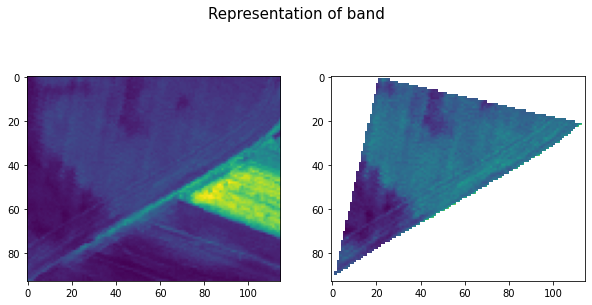

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 145

axs[0].imshow(arr[band_id,:,:].data)
axs[1].imshow(arr[band_id,:,:])
plt.suptitle(f'Representation of band', fontsize=15)
plt.show()

In [65]:
tensor_data = torch.as_tensor(arr)
tensor_data

tensor([[[ 275,  268,  279,  ...,  309,  338,  281],
         [ 250,  261,  276,  ...,  357,  336,  365],
         [ 243,  251,  251,  ...,  337,  295,  304],
         ...,
         [ 363,  359,  354,  ...,  268,  275,  268],
         [ 381,  345,  378,  ...,  295,  284,  287],
         [ 398,  428,  424,  ...,  297,  296,  318]],

        [[ 271,  270,  274,  ...,  308,  342,  283],
         [ 255,  262,  277,  ...,  357,  338,  372],
         [ 250,  251,  250,  ...,  338,  295,  301],
         ...,
         [ 366,  359,  360,  ...,  264,  269,  265],
         [ 377,  351,  384,  ...,  296,  283,  288],
         [ 402,  434,  433,  ...,  296,  302,  315]],

        [[ 266,  267,  264,  ...,  299,  341,  280],
         [ 254,  261,  275,  ...,  353,  331,  375],
         [ 251,  246,  249,  ...,  334,  289,  302],
         ...,
         [ 365,  356,  357,  ...,  258,  266,  257],
         [ 378,  348,  380,  ...,  292,  279,  284],
         [ 403,  432,  427,  ...,  296,  299,  319]],

In [66]:
tensor_data.shape

torch.Size([150, 93, 115])

In [67]:
tensor_mask_bool = torch.as_tensor(arr.mask)
tensor_mask_bool

tensor([[[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True, False, False,  ...,  True,  True,  True],
         [ True, False,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True, False, False,  ...,  True,  True,  True],
         [ True, False,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True, False, False,  ...,  True,  True,  True],
         [

In [73]:
tensor_mask_bool.shape

torch.Size([150, 93, 115])

In [177]:
tensor_data_masked = torch.mul(tensor_data, tensor_mask_bool)
tensor_data_masked

tensor([[[ 275,  268,  279,  ...,  309,  338,  281],
         [ 250,  261,  276,  ...,  357,  336,  365],
         [ 243,  251,  251,  ...,  337,  295,  304],
         ...,
         [ 363,    0,    0,  ...,  268,  275,  268],
         [ 381,    0,  378,  ...,  295,  284,  287],
         [ 398,  428,  424,  ...,  297,  296,  318]],

        [[ 271,  270,  274,  ...,  308,  342,  283],
         [ 255,  262,  277,  ...,  357,  338,  372],
         [ 250,  251,  250,  ...,  338,  295,  301],
         ...,
         [ 366,    0,    0,  ...,  264,  269,  265],
         [ 377,    0,  384,  ...,  296,  283,  288],
         [ 402,  434,  433,  ...,  296,  302,  315]],

        [[ 266,  267,  264,  ...,  299,  341,  280],
         [ 254,  261,  275,  ...,  353,  331,  375],
         [ 251,  246,  249,  ...,  334,  289,  302],
         ...,
         [ 365,    0,    0,  ...,  258,  266,  257],
         [ 378,    0,  380,  ...,  292,  279,  284],
         [ 403,  432,  427,  ...,  296,  299,  319]],

In [178]:
tensor_data_masked.shape

torch.Size([150, 93, 115])

In [285]:
def pad_to_minimum_size(min_size, image):
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2
        print(h_diff, w_diff)
        
        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)
        
        print(h_pad1, h_pad2, w_pad1, w_pad2)
        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)
    

In [286]:
pad_to_minimum_size(300, tensor_data_masked).shape

103.5 92.5
103 104 92 93


torch.Size([150, 300, 300])

### Load mean and std values of training dataset

In [24]:
means_stds_arrays = np.load(os.path.join(train_data_directory, 'means_stds_values_training_data.npz'))
means = np.array(means_stds_arrays['means'])
stds = np.array(means_stds_arrays['stds'])

In [23]:
tensor_data_masked_normalized = transforms.functional.normalize(torch.as_tensor(tensor_data_masked, dtype=torch.float), mean=means.tolist(), std=stds.tolist())
tensor_data_masked_normalized

NameError: name 'tensor_data_masked' is not defined

In [20]:
temp_gt = pd.read_csv(os.path.join(train_data_directory, 'train_gt.csv'))[['P','K','Mg','pH']]

In [22]:
temp_gt

,P,K,Mg,pH
0,45.1,188.0,179.0,7.2
1,44.8,205.0,188.0,7.0
2,44.4,207.0,145.0,6.8
3,46.5,204.0,143.0,6.8
4,52.0,212.0,167.0,6.7
...,...,...,...,...
1727,40.8,133.0,132.0,6.2
1728,42.7,192.0,126.0,6.5
1729,39.4,180.0,122.0,6.5
1730,37.3,162.0,127.0,6.5


In [25]:
temp_gt.loc[1, 'P']

44.8

### Dataset definition

In [57]:
class HyperViewDataset(Dataset):
    def __init__(self, gt_file, img_dir, transform=True, means=None, stds=None, train_transforms=False):
        self.img_dir = img_dir
        if gt_file is not None:
            self.gt = pd.read_csv(gt_file)[['P','K','Mg','pH']]
        else:
            self.gt = None
        self.transform = transform # whether to perform transformation of input data
        self.train_transforms = train_transforms # whether to perform transformations like on training data
        
        if self.train_transforms:
            self.training_transforms_composition = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.4), transforms.RandomVerticalFlip(p=0.4)])
        
        self.means = means # mean values for every band used to normalize data
        self.stds = stds # std values for every band used to normalize data
        
        self.img_files = np.array(
            sorted(
                glob(os.path.join(img_dir, "*.npz")),
                key=lambda x: int(os.path.basename(x).replace(".npz", "")),
            )
        )
    
    def pad_to_minimum_size(self, min_size, image):
        # pads numpy array to defined in `min_size` minimum size of array (w, h)
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2
        
        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)
        
        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        # load hyperspectral image to array
        img_arr = np.ma.MaskedArray(**np.load(self.img_files[idx]))
        img_tensor = torch.as_tensor(img_arr.data, dtype=torch.float)
        img_tensor_mask = torch.as_tensor(img_arr.mask)
        img_masked_tensor = torch.mul(img_tensor, img_tensor_mask)
        
        if self.transform:
            img_masked_tensor_transformed = transforms.functional.normalize(img_masked_tensor, mean=self.means.tolist(), std=self.stds.tolist())
            img_masked_tensor_transformed = self.pad_to_minimum_size(300, img_masked_tensor_transformed)
            if self.train_transforms:
                img_masked_tensor_transformed = self.training_transforms_composition(img_masked_tensor_transformed)
            img_result_tensor = img_masked_tensor_transformed
        else:
            img_result_tensor = img_masked_tensor
        # load labels
        if self.gt is not None:
            P_gt = self.gt.loc[idx, 'P']
            K_gt = self.gt.loc[idx, 'K']
            Mg_gt = self.gt.loc[idx, 'Mg']
            pH_gt = self.gt.loc[idx, 'pH']

            sample = {'image': img_result_tensor, 'P': P_gt, 'K': K_gt, 'Mg': Mg_gt, 'pH': pH_gt}
        else:
            sample = {'image': img_result_tensor}
        
        return sample

In [58]:
train_data_whole = HyperViewDataset(os.path.join(train_data_directory, 'train_gt.csv'), os.path.join(train_data_directory, 'train_data'), True, means, stds, train_transforms=True)

In [59]:
train_dataset, validation_dataset = random_split(train_data_whole, [1400, 332])

### Model Definition

In [60]:
import torchvision
from torchvision import datasets, models, transforms

In [61]:
class ResNetCNN(nn.Module):
    def __init__(self, pretrained):
        super().__init__()
        self.resnet_model = models.resnet50(pretrained=False)
        
        self.resnet_model.conv1 = nn.Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet_model.fc = nn.Linear(2048, 4, bias=True)
        
    def forward(self, x):
        x = self.resnet_model(x)
#         return {'P': x[0], 'K': x[1], 'Mg': x[2], 'pH': x[3]}
        return x

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [63]:
BATCH_SIZE = 12
EPOCHS = 300

In [64]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4)

### Overfitting on single batch of data

In [65]:
model = ResNetCNN(pretrained=False)
model.to(device)

ResNetCNN(
  (resnet_model): ResNet(
    (conv1): Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [66]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [67]:
train_data_single_batch = next(iter(train_dataloader))

In [68]:
train_data_single_batch

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...

In [69]:
train_data_single_batch['image'][0].shape

torch.Size([150, 300, 300])

In [70]:
train_data_single_batch['image'].to(device, dtype=torch.float).shape

torch.Size([12, 150, 300, 300])

In [71]:
output = model(train_data_single_batch['image'].to(device, dtype=torch.float))

In [72]:
output

tensor([[ 0.1798, -0.1635, -0.5786, -0.3722],
        [ 0.0964, -0.1394, -0.5824, -0.4865],
        [ 0.5135, -0.4891, -0.6564, -0.3491],
        [ 0.6750, -0.2748, -0.4139, -0.3157],
        [ 0.1518, -0.1233, -0.6302, -0.4575],
        [ 0.1182, -0.1826, -0.5903, -0.4389],
        [ 0.1249, -0.1486, -0.6218, -0.5044],
        [ 0.5988, -0.2427, -0.4712, -0.2731],
        [ 0.2007, -0.1942, -0.6483, -0.4914],
        [ 0.1219, -0.1879, -0.6243, -0.4579],
        [ 0.1338, -0.1392, -0.6107, -0.4618],
        [ 0.1364, -0.1545, -0.5908, -0.5209]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [73]:
stacked_gt = torch.stack((train_data_single_batch['P'], train_data_single_batch['K'], train_data_single_batch['Mg'], train_data_single_batch['pH']))
stacked_gt

tensor([[109.0000,  47.2000, 114.0000,  89.0000,  78.9000,  53.1000,  37.2000,
          66.4000,  59.4000,  41.2000,  81.9000, 105.0000],
        [323.0000, 224.0000, 401.0000, 236.0000, 233.0000, 153.0000, 229.0000,
         302.0000, 277.0000, 232.0000, 246.0000, 226.0000],
        [148.0000,  99.4000, 145.0000, 146.0000, 136.0000, 116.0000, 155.0000,
         241.0000, 110.0000, 196.0000, 173.0000, 124.0000],
        [  7.1000,   7.2200,   6.7000,   7.0000,   7.0000,   7.0000,   7.0000,
           6.7000,   6.8000,   6.7300,   6.4000,   7.0000]],
       dtype=torch.float64)

In [74]:
stacked_gt = stacked_gt.transpose(0, 1).to(device)

In [75]:
stacked_gt

tensor([[109.0000, 323.0000, 148.0000,   7.1000],
        [ 47.2000, 224.0000,  99.4000,   7.2200],
        [114.0000, 401.0000, 145.0000,   6.7000],
        [ 89.0000, 236.0000, 146.0000,   7.0000],
        [ 78.9000, 233.0000, 136.0000,   7.0000],
        [ 53.1000, 153.0000, 116.0000,   7.0000],
        [ 37.2000, 229.0000, 155.0000,   7.0000],
        [ 66.4000, 302.0000, 241.0000,   6.7000],
        [ 59.4000, 277.0000, 110.0000,   6.8000],
        [ 41.2000, 232.0000, 196.0000,   6.7300],
        [ 81.9000, 246.0000, 173.0000,   6.4000],
        [105.0000, 226.0000, 124.0000,   7.0000]], device='cuda:0',
       dtype=torch.float64)

In [76]:
loss_func(output, stacked_gt)

tensor(24893.5944, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)

In [77]:
img_data_device = train_data_single_batch['image'].to(device, dtype=torch.float)
stacked_gt_device = torch.stack((train_data_single_batch['P'], train_data_single_batch['K'], train_data_single_batch['Mg'], train_data_single_batch['pH'])).transpose(0,1).to(device, 
    dtype=torch.float)

model = ResNext(False).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

for epoch in range(301):
    model.train()
    
    output = model(img_data_device)
    loss = loss_func(output, stacked_gt_device)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    output_cpu = output.detach().cpu().numpy()
    stacked_gt_cpu = stacked_gt_device.cpu().numpy()

    # Calculate MSE for each class
    mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
    
    if epoch%10 == 0:
        print(f'epoch: {epoch}, loss: {loss.data.cpu().numpy()}, MSE: {mse}')

epoch: 0, loss: 24956.310546875, MSE: [6.1410352e+03 6.9885836e+04 2.3751920e+04 4.6464859e+01]
epoch: 10, loss: 1518.6732177734375, MSE: [1722.6559   2881.176    1424.8094     46.051884]
epoch: 20, loss: 877.126953125, MSE: [ 684.3997  1305.9894  1504.3927    13.72609]
epoch: 30, loss: 534.490966796875, MSE: [ 479.2733    270.52557  1383.5444      4.620686]
epoch: 40, loss: 462.8389587402344, MSE: [4.7761514e+02 2.0838879e+02 1.1643745e+03 9.7746831e-01]
epoch: 50, loss: 448.3454284667969, MSE: [4.4885449e+02 1.7543495e+02 1.1685786e+03 5.1361191e-01]
epoch: 60, loss: 428.02362060546875, MSE: [4.3191055e+02 1.5160112e+02 1.1284227e+03 1.6011237e-01]
epoch: 70, loss: 406.15289306640625, MSE: [4.2594604e+02 1.0898342e+02 1.0894912e+03 1.9091380e-01]
epoch: 80, loss: 420.7208251953125, MSE: [4.2778860e+02 3.0031277e+02 9.5454633e+02 2.3575817e-01]
epoch: 90, loss: 495.595947265625, MSE: [499.58505   703.4086    777.889       1.5010055]
epoch: 100, loss: 373.1773681640625, MSE: [4.7363269

### Training

In [114]:
model_name = 'resnet50_BATCHSIZE_12_AdamW_LR_0_01_ReduceLROnPlateau_Factor0_6_Threshold_0_0001'

In [115]:
model = ResNetCNN(False).to(device)

In [116]:
wandb.watch(model, log="None", log_freq=20)

[]

In [117]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [118]:
loss_func = torch.nn.MSELoss()

#### Find LR

In [87]:
from torch_lr_finder.lr_finder import TrainDataLoaderIter

In [88]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return (torch.as_tensor(batch_data['image'], dtype=torch.float), 
                torch.as_tensor(torch.stack((batch_data['P'], batch_data['K'], batch_data['Mg'], batch_data['pH'])).transpose(0,1), dtype=torch.float))

In [89]:
lr_finder = LRFinder(model, optimizer, loss_func, device=device)
lr_finder.range_test(CustomTrainIter(train_dataloader), start_lr=0.00001, end_lr=100, num_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 6.73E-03


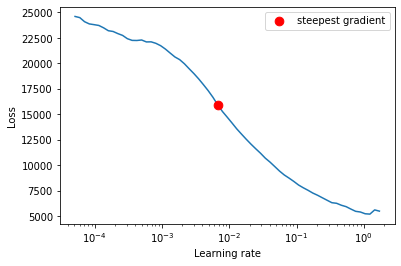

In [90]:
lr_finder.plot()
lr_finder.reset()

In [91]:
6.73E-03

0.00673

#### Continue training

In [119]:
patience_scheduler_overfit = 5
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
                                                       factor=0.6, patience = patience_scheduler_overfit,
                                                       threshold=0.0001, threshold_mode='abs')

In [120]:
early_stopping = utils.EarlyStopping(patience=(2*patience_scheduler_overfit)+3, verbose=True,
                               path=os.path.join(saved_models_directory, 'checkpoint_state_dict.pth'))

In [121]:
config = wandb.config
config.model = 'resnet50'
config.optimizer =  'AdamW'
config.learning_rate_start = optimizer.param_groups[0]["lr"]
# config.momentum = optimizer.param_groups[0]["momentum"]
config.momentum = None
config.weight_decay = optimizer.param_groups[0]["weight_decay"]
config.scheduler =  'ReduceLROnPlateau'
config.scheduler_factor =  0.6
config.scheduler_patience =  5
config.scheduler_threshold =  0.0001
config.batch_size = BATCH_SIZE

In [122]:
previous_epochs = 0 # how many epochs have been done previously if resuming

In [123]:
for epoch in range(previous_epochs, EPOCHS+previous_epochs):
    # TRAINING Part
    model.train()
    train_loss = []
    mse_train_list = []
    
    bar = tqdm(train_dataloader, position=0, leave=False, desc=f'epoch {epoch} training data')
    i = 0
    for train_data in bar: # for each training step
        i += 1
        img_data_device = train_data['image'].to(device, dtype=torch.float)
        stacked_gt_device = torch.stack((train_data['P'], train_data['K'], train_data['Mg'], train_data['pH'])).transpose(0,1).to(device, dtype=torch.float)
        
        output = model(img_data_device)
        
        loss = loss_func(output, stacked_gt_device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss)
        
        output_cpu = output.detach().cpu().numpy()
        stacked_gt_cpu = stacked_gt_device.cpu().numpy()
        
        # Calculate MSE for each class
        mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
        mse_train_list.append(mse)
        
        if i % 10 == 0: # log every 10 batches
            train_log_dict = dict()
            train_log_dict['batch_number'] = i
            train_log_dict['epoch'] = epoch
            train_log_dict['train_batch_loss'] = loss 
            train_log_dict['train_batch_MSE_P'] = mse[0]
            train_log_dict['train_batch_MSE_K'] = mse[1]
            train_log_dict['train_batch_MSE_Mg'] = mse[2]
            train_log_dict['train_batch_MSE_pH'] = mse[3]
            wandb.log(train_log_dict)
    
    avg_train_loss = torch.stack(train_loss).mean().item()
    avg_train_mse = torch.as_tensor(np.array(mse_train_list)).mean(axis=0).numpy().tolist()
    
    print(f'epoch: {epoch}, LR: {optimizer.param_groups[0]["lr"]}, train loss: {avg_train_loss}, train MSE: {avg_train_mse}')
    wandb.log({'epoch': epoch, 'average_train_loss':avg_train_loss, 'average_train_MSE_P': avg_train_mse[0], 'average_train_MSE_K': avg_train_mse[1],
              'average_train_MSE_Mg': avg_train_mse[2], 'average_train_MSE_pH': avg_train_mse[3]})
    
    # VALIDATION Part
    model.eval()
    val_bar = tqdm(validation_dataloader, position=0, leave=False, desc=f'epoch {epoch} validation data')
    with torch.no_grad():
        val_loss = []
        mse_val_list = []
        for val_data in val_bar:
            img_data_device = val_data['image'].to(device, dtype=torch.float)
            stacked_gt_device = torch.stack((val_data['P'], val_data['K'], val_data['Mg'], val_data['pH'])).transpose(0,1).to(device, dtype=torch.float)
            
            output = model(img_data_device)
            
            loss = loss_func(output, stacked_gt_device)
            val_loss.append(loss)
            
            output_cpu = output.detach().cpu().numpy()
            stacked_gt_cpu = stacked_gt_device.cpu().numpy()

            # Calculate MSE for each class
            mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
            mse_val_list.append(mse)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        avg_val_mse = torch.as_tensor(np.array(mse_val_list)).mean(axis=0).numpy().tolist()
        
        print(f'epoch: {epoch}, validation loss: {avg_val_loss}, validation MSE: {avg_val_mse}')
        wandb.log({'epoch': epoch, 'average_val_loss': avg_val_loss, 'average_val_MSE_P': avg_val_mse[0], 'average_val_MSE_K': avg_val_mse[1], 
                   'average_val_MSE_Mh': avg_val_mse[2], 'average_val_MSE_pH': avg_val_mse[3]})
        
        scheduler.step(avg_val_loss)
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break


epoch 0 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 0, LR: 0.01, train loss: 2282.66064453125, train MSE: [1065.45751953125, 5649.50341796875, 2406.46142578125, 9.219552993774414]


epoch 0 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 0, validation loss: 1604.51171875, validation MSE: [1132.1688232421875, 3613.537841796875, 1671.31298828125, 1.027095079421997]
Validation loss decreased (inf --> 1604.511719).  Saving model ...


epoch 1 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 1, LR: 0.01, train loss: 1679.6767578125, train MSE: [938.2486572265625, 4099.15673828125, 1681.15234375, 0.14925342798233032]


epoch 1 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 1, validation loss: 1575.699951171875, validation MSE: [1078.8350830078125, 3565.029052734375, 1657.409912109375, 1.5255926847457886]
Validation loss decreased (1604.511719 --> 1575.699951).  Saving model ...


epoch 2 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 2, LR: 0.01, train loss: 1689.3477783203125, train MSE: [940.5868530273438, 4111.9521484375, 1704.713623046875, 0.13799016177654266]


epoch 2 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 2, validation loss: 2613.31494140625, validation MSE: [956.6680297851562, 6313.23193359375, 3180.75048828125, 2.6090245246887207]
EarlyStopping counter: 1 out of 13


epoch 3 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 3, LR: 0.01, train loss: 1679.339599609375, train MSE: [938.9424438476562, 4078.707763671875, 1699.5938720703125, 0.11381404101848602]


epoch 3 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 3, validation loss: 1622.1290283203125, validation MSE: [1125.6920166015625, 3712.994873046875, 1649.24560546875, 0.5825238823890686]
EarlyStopping counter: 2 out of 13


epoch 4 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 4, LR: 0.01, train loss: 1667.5654296875, train MSE: [933.42626953125, 4043.546142578125, 1693.1705322265625, 0.11833682656288147]


epoch 4 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 4, validation loss: 1876.4207763671875, validation MSE: [1149.41796875, 4464.923828125, 1891.215087890625, 0.12580078840255737]
EarlyStopping counter: 3 out of 13


epoch 5 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 5, LR: 0.01, train loss: 1683.3341064453125, train MSE: [938.7030029296875, 4089.824951171875, 1704.6766357421875, 0.13133034110069275]


epoch 5 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 5, validation loss: 2036.3187255859375, validation MSE: [1232.029541015625, 5071.2822265625, 1841.720947265625, 0.2415936440229416]
EarlyStopping counter: 4 out of 13


epoch 6 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 6, LR: 0.01, train loss: 1699.8924560546875, train MSE: [928.1434936523438, 4163.42919921875, 1707.7083740234375, 0.2886916399002075]


epoch 6 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 6, validation loss: 1562.1141357421875, validation MSE: [1060.74853515625, 3507.158447265625, 1680.4366455078125, 0.1125398576259613]
Validation loss decreased (1575.699951 --> 1562.114136).  Saving model ...


epoch 7 training data:   0%|          | 0/116 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f708a3ff5f0>
Traceback (most recent call last):
  File "/home/CENAGIS/jcharyton/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/CENAGIS/jcharyton/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f708a3ff5f0>
Traceback (most recent call last):
  File "/home/CENAGIS/jcharyton/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/CENAGIS/jcharyton/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.

epoch: 7, LR: 0.01, train loss: 1663.771240234375, train MSE: [919.9837646484375, 4043.445068359375, 1691.5360107421875, 0.11998783051967621]


epoch 7 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f708a3ff5f0>
Traceback (most recent call last):
  File "/home/CENAGIS/jcharyton/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/CENAGIS/jcharyton/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f708a3ff5f0>
Traceback (most recent call last):
  File "/home/CENAGIS/jcharyton/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/CENAGIS/jcharyton/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.

epoch: 7, validation loss: 1683.623046875, validation MSE: [1048.1044921875, 3651.910888671875, 2034.32470703125, 0.15193986892700195]
EarlyStopping counter: 1 out of 13


epoch 8 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 8, LR: 0.01, train loss: 1656.440673828125, train MSE: [911.6522827148438, 4050.650634765625, 1663.3465576171875, 0.1127416342496872]


epoch 8 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 8, validation loss: 1584.0810546875, validation MSE: [1041.9630126953125, 3627.59033203125, 1666.635986328125, 0.13412806391716003]
EarlyStopping counter: 2 out of 13


epoch 9 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 9, LR: 0.01, train loss: 1644.98779296875, train MSE: [907.1724243164062, 4023.515869140625, 1649.1524658203125, 0.10986080765724182]


epoch 9 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 9, validation loss: 1935.3380126953125, validation MSE: [989.4411010742188, 4012.111572265625, 2739.67529296875, 0.12420131266117096]
EarlyStopping counter: 3 out of 13


epoch 10 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 10, LR: 0.01, train loss: 1644.56494140625, train MSE: [910.6580200195312, 4020.152587890625, 1647.342041015625, 0.10685274004936218]


epoch 10 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 10, validation loss: 1593.2967529296875, validation MSE: [953.4632568359375, 3764.575927734375, 1655.045166015625, 0.10240348428487778]
EarlyStopping counter: 4 out of 13


epoch 11 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 11, LR: 0.01, train loss: 1645.966064453125, train MSE: [907.3992919921875, 4026.44873046875, 1649.905517578125, 0.10942166298627853]


epoch 11 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 11, validation loss: 1688.5150146484375, validation MSE: [1051.4559326171875, 3888.080322265625, 1814.1727294921875, 0.3505399823188782]
EarlyStopping counter: 5 out of 13


epoch 12 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 12, LR: 0.01, train loss: 1652.9345703125, train MSE: [913.1224365234375, 4027.95068359375, 1670.5048828125, 0.1600014567375183]


epoch 12 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 12, validation loss: 1621.762939453125, validation MSE: [1026.2705078125, 3584.721923828125, 1875.9461669921875, 0.11285752803087234]
EarlyStopping counter: 6 out of 13


epoch 13 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 13, LR: 0.006, train loss: 1615.9390869140625, train MSE: [892.375, 3963.46923828125, 1607.787841796875, 0.12337471544742584]


epoch 13 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 13, validation loss: 1554.349609375, validation MSE: [951.9843139648438, 3607.83447265625, 1657.4969482421875, 0.08243507146835327]
Validation loss decreased (1562.114136 --> 1554.349609).  Saving model ...


epoch 14 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 14, LR: 0.006, train loss: 1582.407958984375, train MSE: [878.2012939453125, 3861.50732421875, 1589.82666015625, 0.09648352861404419]


epoch 14 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 14, validation loss: 1541.5107421875, validation MSE: [930.4458618164062, 3557.9306640625, 1677.5635986328125, 0.10283675789833069]
Validation loss decreased (1554.349609 --> 1541.510742).  Saving model ...


epoch 15 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 15, LR: 0.006, train loss: 1568.6446533203125, train MSE: [874.671142578125, 3822.132568359375, 1577.679443359375, 0.0953047126531601]


epoch 15 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 15, validation loss: 1517.4351806640625, validation MSE: [920.5659790039062, 3461.588623046875, 1687.4630126953125, 0.1227627843618393]
Validation loss decreased (1541.510742 --> 1517.435181).  Saving model ...


epoch 16 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 16, LR: 0.006, train loss: 1556.643798828125, train MSE: [877.3709106445312, 3781.75341796875, 1567.3507080078125, 0.10001137852668762]


epoch 16 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 16, validation loss: 1607.0960693359375, validation MSE: [902.6452026367188, 3653.252197265625, 1872.070556640625, 0.4154917299747467]
EarlyStopping counter: 1 out of 13


epoch 17 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 17, LR: 0.006, train loss: 1565.5089111328125, train MSE: [878.28369140625, 3817.52783203125, 1566.1116943359375, 0.11261782795190811]


epoch 17 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 17, validation loss: 1488.9049072265625, validation MSE: [931.8707275390625, 3371.379638671875, 1652.3046875, 0.06420505791902542]
Validation loss decreased (1517.435181 --> 1488.904907).  Saving model ...


epoch 18 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 18, LR: 0.006, train loss: 1557.3870849609375, train MSE: [875.6932373046875, 3789.943359375, 1563.8074951171875, 0.1038830354809761]


epoch 18 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 18, validation loss: 1532.179931640625, validation MSE: [933.4959716796875, 3489.163818359375, 1705.992431640625, 0.06756407022476196]
EarlyStopping counter: 1 out of 13


epoch 19 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 19, LR: 0.006, train loss: 1565.3028564453125, train MSE: [880.8645629882812, 3824.619384765625, 1555.6192626953125, 0.10761133581399918]


epoch 19 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 19, validation loss: 1510.67041015625, validation MSE: [919.115478515625, 3422.05615234375, 1701.4337158203125, 0.07621980458498001]
EarlyStopping counter: 2 out of 13


epoch 20 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 20, LR: 0.006, train loss: 1554.76123046875, train MSE: [878.9114379882812, 3772.2587890625, 1567.758056640625, 0.11616135388612747]


epoch 20 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 20, validation loss: 1505.929931640625, validation MSE: [917.8079223632812, 3394.10595703125, 1711.7352294921875, 0.0705316886305809]
EarlyStopping counter: 3 out of 13


epoch 21 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 21, LR: 0.006, train loss: 1542.4349365234375, train MSE: [875.585693359375, 3751.211181640625, 1542.8284912109375, 0.11380203813314438]


epoch 21 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 21, validation loss: 1514.5028076171875, validation MSE: [919.333740234375, 3429.644775390625, 1708.945556640625, 0.08642128854990005]
EarlyStopping counter: 4 out of 13


epoch 22 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 22, LR: 0.006, train loss: 1528.809814453125, train MSE: [875.905517578125, 3695.0390625, 1544.163818359375, 0.13102512061595917]


epoch 22 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 22, validation loss: 1505.0789794921875, validation MSE: [926.0812377929688, 3420.1630859375, 1673.906005859375, 0.16557635366916656]
EarlyStopping counter: 5 out of 13


epoch 23 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 23, LR: 0.006, train loss: 1531.2711181640625, train MSE: [873.3756713867188, 3707.836669921875, 1543.7216796875, 0.15001745522022247]


epoch 23 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 23, validation loss: 1532.493896484375, validation MSE: [947.356201171875, 3541.940185546875, 1640.484375, 0.194970041513443]
EarlyStopping counter: 6 out of 13


epoch 24 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 24, LR: 0.0036, train loss: 1487.4779052734375, train MSE: [859.5303344726562, 3584.01220703125, 1506.27001953125, 0.09874825179576874]


epoch 24 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 24, validation loss: 1446.4405517578125, validation MSE: [917.0682373046875, 3261.1982421875, 1607.3807373046875, 0.11442694813013077]
Validation loss decreased (1488.904907 --> 1446.440552).  Saving model ...


epoch 25 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 25, LR: 0.0036, train loss: 1469.0126953125, train MSE: [856.3272094726562, 3535.151123046875, 1484.484130859375, 0.08825995028018951]


epoch 25 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 25, validation loss: 1490.5107421875, validation MSE: [920.9749755859375, 3422.754638671875, 1618.1531982421875, 0.16022846102714539]
EarlyStopping counter: 1 out of 13


epoch 26 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 26, LR: 0.0036, train loss: 1473.52294921875, train MSE: [863.57177734375, 3538.70947265625, 1491.7161865234375, 0.0941094309091568]


epoch 26 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 26, validation loss: 1477.29345703125, validation MSE: [933.5315551757812, 3372.448974609375, 1603.0987548828125, 0.09407628327608109]
EarlyStopping counter: 2 out of 13


epoch 27 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 27, LR: 0.0036, train loss: 1461.4921875, train MSE: [858.153076171875, 3504.63232421875, 1483.0921630859375, 0.09049791097640991]


epoch 27 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 27, validation loss: 1493.9498291015625, validation MSE: [934.431640625, 3432.902099609375, 1608.320556640625, 0.1443057656288147]
EarlyStopping counter: 3 out of 13


epoch 28 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 28, LR: 0.0036, train loss: 1463.1761474609375, train MSE: [855.5086669921875, 3509.6181640625, 1487.4893798828125, 0.08882346004247665]


epoch 28 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 28, validation loss: 1443.945556640625, validation MSE: [917.6911010742188, 3257.75634765625, 1600.2093505859375, 0.12579897046089172]
Validation loss decreased (1446.440552 --> 1443.945557).  Saving model ...


epoch 29 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 29, LR: 0.0036, train loss: 1447.482177734375, train MSE: [857.4392700195312, 3448.037353515625, 1484.3531494140625, 0.09899792820215225]


epoch 29 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 29, validation loss: 1459.9326171875, validation MSE: [932.2714233398438, 3317.324462890625, 1590.056884765625, 0.07721284031867981]
EarlyStopping counter: 1 out of 13


epoch 30 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 30, LR: 0.0036, train loss: 1469.7208251953125, train MSE: [858.891845703125, 3536.83544921875, 1483.053466796875, 0.10165303200483322]


epoch 30 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 30, validation loss: 1466.2705078125, validation MSE: [930.1557006835938, 3318.372802734375, 1616.4849853515625, 0.06803835928440094]
EarlyStopping counter: 2 out of 13


epoch 31 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 31, LR: 0.0036, train loss: 1472.6640625, train MSE: [860.10546875, 3552.35888671875, 1478.091552734375, 0.0995500236749649]


epoch 31 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 31, validation loss: 1506.4617919921875, validation MSE: [943.010009765625, 3497.769287109375, 1584.964111328125, 0.10376463830471039]
EarlyStopping counter: 3 out of 13


epoch 32 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 32, LR: 0.0036, train loss: 1460.0045166015625, train MSE: [859.4607543945312, 3500.40087890625, 1480.0477294921875, 0.10877185314893723]


epoch 32 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 32, validation loss: 1516.9248046875, validation MSE: [940.3269653320312, 3507.517822265625, 1619.764892578125, 0.08921229094266891]
EarlyStopping counter: 4 out of 13


epoch 33 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 33, LR: 0.0036, train loss: 1439.96826171875, train MSE: [853.4742431640625, 3424.248046875, 1482.049072265625, 0.10100270062685013]


epoch 33 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 33, validation loss: 1481.3623046875, validation MSE: [934.368896484375, 3374.211181640625, 1616.7982177734375, 0.07073421031236649]
EarlyStopping counter: 5 out of 13


epoch 34 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 34, LR: 0.0036, train loss: 1443.234130859375, train MSE: [854.4647827148438, 3443.863037109375, 1474.5050048828125, 0.10353358089923859]


epoch 34 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 34, validation loss: 1425.3170166015625, validation MSE: [921.4207153320312, 3172.14111328125, 1607.6038818359375, 0.1019802913069725]
Validation loss decreased (1443.945557 --> 1425.317017).  Saving model ...


epoch 35 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 35, LR: 0.0036, train loss: 1424.882568359375, train MSE: [855.9568481445312, 3374.1220703125, 1469.3389892578125, 0.112411268055439]


epoch 35 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 35, validation loss: 1480.6419677734375, validation MSE: [941.95703125, 3319.429443359375, 1661.003662109375, 0.17725004255771637]
EarlyStopping counter: 1 out of 13


epoch 36 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 36, LR: 0.0036, train loss: 1425.2470703125, train MSE: [848.6768188476562, 3379.82861328125, 1472.34765625, 0.13478341698646545]


epoch 36 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 36, validation loss: 1487.18115234375, validation MSE: [913.9354248046875, 3416.885498046875, 1617.8114013671875, 0.09196557104587555]
EarlyStopping counter: 2 out of 13


epoch 37 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 37, LR: 0.0036, train loss: 1409.4539794921875, train MSE: [849.281982421875, 3316.051025390625, 1472.3858642578125, 0.09671887010335922]


epoch 37 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 37, validation loss: 2555.91259765625, validation MSE: [1150.8719482421875, 7423.15869140625, 1649.369384765625, 0.24933059513568878]
EarlyStopping counter: 3 out of 13


epoch 38 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 38, LR: 0.0036, train loss: 1432.200439453125, train MSE: [854.38232421875, 3419.196044921875, 1455.1029052734375, 0.12004067748785019]


epoch 38 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 38, validation loss: 1426.2847900390625, validation MSE: [928.9539794921875, 3195.09033203125, 1580.9837646484375, 0.10996980965137482]
EarlyStopping counter: 4 out of 13


epoch 39 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 39, LR: 0.0036, train loss: 1406.4957275390625, train MSE: [850.9181518554688, 3318.93310546875, 1456.004150390625, 0.12742772698402405]


epoch 39 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 39, validation loss: 1517.6881103515625, validation MSE: [952.9219360351562, 3513.431640625, 1604.2525634765625, 0.14616753160953522]
EarlyStopping counter: 5 out of 13


epoch 40 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 40, LR: 0.0036, train loss: 1404.6312255859375, train MSE: [848.519287109375, 3312.4482421875, 1457.4259033203125, 0.13112413883209229]


epoch 40 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 40, validation loss: 1448.6207275390625, validation MSE: [941.8579711914062, 3251.701171875, 1600.7618408203125, 0.1615319848060608]
EarlyStopping counter: 6 out of 13


epoch 41 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 41, LR: 0.00216, train loss: 1382.4610595703125, train MSE: [851.5469970703125, 3240.471435546875, 1437.7269287109375, 0.09859506785869598]


epoch 41 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 41, validation loss: 1411.5072021484375, validation MSE: [914.1057739257812, 3118.908935546875, 1612.9150390625, 0.09881284832954407]
Validation loss decreased (1425.317017 --> 1411.507202).  Saving model ...


epoch 42 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 42, LR: 0.00216, train loss: 1359.9019775390625, train MSE: [839.6693115234375, 3160.232177734375, 1439.625244140625, 0.08095110207796097]


epoch 42 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 42, validation loss: 1434.798583984375, validation MSE: [917.6902465820312, 3243.78466796875, 1577.6304931640625, 0.08897942304611206]
EarlyStopping counter: 1 out of 13


epoch 43 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 43, LR: 0.00216, train loss: 1339.9000244140625, train MSE: [837.1548461914062, 3097.45751953125, 1424.8992919921875, 0.08900358527898788]


epoch 43 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 43, validation loss: 1406.4864501953125, validation MSE: [910.9069213867188, 3144.85888671875, 1570.083740234375, 0.09650519490242004]
Validation loss decreased (1411.507202 --> 1406.486450).  Saving model ...


epoch 44 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 44, LR: 0.00216, train loss: 1330.8658447265625, train MSE: [835.5821533203125, 3065.22216796875, 1422.5723876953125, 0.08666032552719116]


epoch 44 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 44, validation loss: 2208.788330078125, validation MSE: [1016.2661743164062, 5303.5322265625, 2515.152099609375, 0.20272861421108246]
EarlyStopping counter: 1 out of 13


epoch 45 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 45, LR: 0.00216, train loss: 1323.2354736328125, train MSE: [826.8784790039062, 3046.751953125, 1419.2239990234375, 0.08740164339542389]


epoch 45 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 45, validation loss: 1410.9488525390625, validation MSE: [898.8109741210938, 3170.721923828125, 1574.1898193359375, 0.07229539006948471]
EarlyStopping counter: 2 out of 13


epoch 46 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 46, LR: 0.00216, train loss: 1305.0623779296875, train MSE: [831.2667846679688, 2958.2138671875, 1430.6766357421875, 0.09148851037025452]


epoch 46 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 46, validation loss: 1378.0244140625, validation MSE: [901.5015869140625, 3053.65966796875, 1556.8568115234375, 0.07923832535743713]
Validation loss decreased (1406.486450 --> 1378.024414).  Saving model ...


epoch 47 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 47, LR: 0.00216, train loss: 1306.13427734375, train MSE: [827.1549682617188, 2979.4287109375, 1417.86181640625, 0.09168045222759247]


epoch 47 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 47, validation loss: 1458.11083984375, validation MSE: [918.8666381835938, 3314.595947265625, 1598.9078369140625, 0.07221252471208572]
EarlyStopping counter: 1 out of 13


epoch 48 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 48, LR: 0.00216, train loss: 1311.72119140625, train MSE: [829.62451171875, 2992.785888671875, 1424.3831787109375, 0.09080822765827179]


epoch 48 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 48, validation loss: 2102.102294921875, validation MSE: [1015.6358642578125, 5446.10302734375, 1946.4920654296875, 0.17825978994369507]
EarlyStopping counter: 2 out of 13


epoch 49 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 49, LR: 0.00216, train loss: 1300.031005859375, train MSE: [823.4216918945312, 2952.845947265625, 1423.7587890625, 0.0972469374537468]


epoch 49 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 49, validation loss: 1398.8531494140625, validation MSE: [903.77978515625, 3126.29638671875, 1565.267333984375, 0.0689922645688057]
EarlyStopping counter: 3 out of 13


epoch 50 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 50, LR: 0.00216, train loss: 1288.4901123046875, train MSE: [825.6976928710938, 2906.305419921875, 1421.8614501953125, 0.09588491171598434]


epoch 50 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 50, validation loss: 1416.421630859375, validation MSE: [911.0247192382812, 3184.29345703125, 1570.296630859375, 0.07129879295825958]
EarlyStopping counter: 4 out of 13


epoch 51 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 51, LR: 0.00216, train loss: 1277.359375, train MSE: [816.37841796875, 2875.265869140625, 1417.7039794921875, 0.08910315483808517]


epoch 51 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 51, validation loss: 1476.246826171875, validation MSE: [925.8961181640625, 3410.54248046875, 1568.4776611328125, 0.07013434916734695]
EarlyStopping counter: 5 out of 13


epoch 52 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 52, LR: 0.00216, train loss: 1278.0792236328125, train MSE: [822.9506225585938, 2877.971923828125, 1411.2913818359375, 0.10297778248786926]


epoch 52 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 52, validation loss: 1401.1146240234375, validation MSE: [918.9415283203125, 3105.607421875, 1579.80615234375, 0.10319925844669342]
EarlyStopping counter: 6 out of 13


epoch 53 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 53, LR: 0.001296, train loss: 1260.838623046875, train MSE: [811.5709838867188, 2818.751953125, 1412.931396484375, 0.1001974493265152]


epoch 53 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 53, validation loss: 1439.399658203125, validation MSE: [921.4794311523438, 3264.99560546875, 1570.9588623046875, 0.16409549117088318]
EarlyStopping counter: 7 out of 13


epoch 54 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 54, LR: 0.001296, train loss: 1242.2943115234375, train MSE: [816.532470703125, 2754.386962890625, 1398.16162109375, 0.09561590850353241]


epoch 54 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 54, validation loss: 1416.852294921875, validation MSE: [896.1705932617188, 3185.589111328125, 1585.5228271484375, 0.1264829784631729]
EarlyStopping counter: 8 out of 13


epoch 55 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 55, LR: 0.001296, train loss: 1225.10107421875, train MSE: [811.16064453125, 2687.31787109375, 1401.837158203125, 0.08796326816082001]


epoch 55 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 55, validation loss: 1502.615478515625, validation MSE: [911.5432739257812, 3428.599853515625, 1670.23583984375, 0.08283860236406326]
EarlyStopping counter: 9 out of 13


epoch 56 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 56, LR: 0.001296, train loss: 1206.8046875, train MSE: [797.4866943359375, 2638.720703125, 1390.9197998046875, 0.09154653549194336]


epoch 56 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 56, validation loss: 1443.540283203125, validation MSE: [886.97119140625, 3337.6650390625, 1549.34716796875, 0.17712335288524628]
EarlyStopping counter: 10 out of 13


epoch 57 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 57, LR: 0.001296, train loss: 1206.9517822265625, train MSE: [804.4032592773438, 2629.9091796875, 1393.3929443359375, 0.10161241888999939]


epoch 57 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 57, validation loss: 1419.4481201171875, validation MSE: [920.51025390625, 3193.52490234375, 1563.5836181640625, 0.17291468381881714]
EarlyStopping counter: 11 out of 13


epoch 58 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 58, LR: 0.001296, train loss: 1186.0447998046875, train MSE: [797.515380859375, 2555.41943359375, 1391.143798828125, 0.10073503106832504]


epoch 58 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 58, validation loss: 1458.9111328125, validation MSE: [925.1400756835938, 3344.5185546875, 1565.7666015625, 0.2194286584854126]
EarlyStopping counter: 12 out of 13


epoch 59 training data:   0%|          | 0/116 [00:00<?, ?it/s]

epoch: 59, LR: 0.0007776, train loss: 1177.0247802734375, train MSE: [798.2337646484375, 2524.983642578125, 1384.7916259765625, 0.08994756639003754]


epoch 59 validation data:   0%|          | 0/27 [00:00<?, ?it/s]

epoch: 59, validation loss: 1510.3177490234375, validation MSE: [904.48974609375, 3541.5341796875, 1595.1466064453125, 0.10013814270496368]
EarlyStopping counter: 13 out of 13
Early stopping


In [124]:
torch.save(model.state_dict(), os.path.join(saved_models_directory, model_name+f'_EPOCHS_{epoch}.pth'))

In [125]:
# rename checkpoint.pth
! mv saved_models/checkpoint_state_dict.pth saved_models/checkpoint_state_dict_ResNet50_01_03_2022.pth

In [127]:
# load saved model
modelLoad = ResNetCNN(False)
modelLoad.load_state_dict(torch.load(os.path.join(saved_models_directory, 'checkpoint_state_dict_ResNet50_01_03_2022.pth')))

<All keys matched successfully>

In [128]:
modelLoad = modelLoad.to(device)

### Predict test dataset

In [129]:
modelLoad.eval()

ResNetCNN(
  (resnet_model): ResNet(
    (conv1): Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [130]:
test_data = HyperViewDataset(None, os.path.join(test_data_directory), True, means, stds, train_transforms=False)

In [131]:
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, pin_memory=True, drop_last=False, num_workers=4)

In [132]:
len(test_data)

1154

In [133]:
output_list = []
bar = tqdm(test_dataloader, position=0, leave=False, desc=f'test data')
for test_data in bar: # for each test step
        img_data_device = test_data['image'].to(device, dtype=torch.float)
        
        output = modelLoad(img_data_device)
        output_cpu = output.detach().cpu().numpy()
        output_list.append(output_cpu)
        

test data:   0%|          | 0/97 [00:00<?, ?it/s]

In [134]:
submission = pd.DataFrame(data = [item for sublist in output_list for item in sublist], columns=["P", "K", "Mg", "pH"])
submission

,P,K,Mg,pH
0,67.938263,218.344086,161.180984,6.825253
1,68.548546,222.100327,157.504303,6.765798
2,68.530670,221.593903,159.119110,6.789208
3,68.359001,220.343628,161.024109,6.819204
4,67.023743,213.949753,164.459534,6.820669
...,...,...,...,...
1149,65.925011,229.315048,165.976944,6.417637
1150,66.678268,228.306366,164.155167,6.644519
1151,66.866524,232.026855,168.493683,6.414111
1152,58.217594,190.050598,169.744553,6.407948


In [135]:
submission.to_csv(os.path.join(submissions_directory, "submission_01_03_2022_ResNet50_Checkpoint.csv"), index_label="sample_index")